<a href="https://colab.research.google.com/github/PureWaterH2O/TechOlympics2024/blob/main/Tech_Olympics_WB2_Rides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction to Time Series & Predicting the Future**
--------------------------------

Welcome to an exciting journey where we unlock the secrets of **predicting the future** using the power of data! Have you ever wondered how meteorologists predict weather weeks in advance? Or how financial experts forecast stock market trends? The answer lies in understanding **time series** and the art of **forecasting**.

**Time series data** is a sequence of data points collected or recorded at successive time intervals. By analyzing this data, we can uncover patterns, trends, and seasonality from the past. This, in turn, empowers us to make educated guesses about what will happen next in the series. It's like having a time machine that doesn't take us forward in time but instead predicts what we're likely to see when we get there.

This notebook will leverage historical Cincinnati street car rides accidents to predict the number of people that will ride in the future.



## Step 1: **Load the Libraries**

What is a Library?
--------------------------------

In Python, a **library** is a collection of reusable code that helps in performing various tasks efficiently. Libraries are like toolkits: they provide pre-written functions and tools that you can use to accomplish specific tasks without writing code from scratch.

In [50]:
import calendar

import requests  # Used for making HTTP requests to fetch data from the internet.

import pandas as pd  # Pandas library provides easy-to-use data structures and data analysis tools.

import matplotlib.pyplot as plt  # Matplotlib's pyplot: used for creating static, interactive, and animated visualizations.

import matplotlib.dates as mdates  # Matplotlib's dates module: provides functionalities to handle and format date data on plots.

import datetime as dt  # Datetime module: used for manipulating dates and times.

import pytz  # Pytz library: used for working with time zone information.

# Statsmodels' tsa (time series analysis) module:
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # ExponentialSmoothing: used for forecasting time series data using methods like Holt-Winters.

from prophet import Prophet # Prophet, developed by Facebook, is a library for forecasting with time series data that accommodates seasonal variations and holiday effects, making it highly versatile for various forecasting tasks.

## Step 2: **Getting the Data**

## What is an API?

An **API (Application Programming Interface)** is a set of rules that allows different software applications to communicate with each other. APIs are used to enable the interaction between data, applications, and devices. They are crucial in fetching data from external sources, in our case we are pulling data from the cincinnati-oh.gov web server.

In [51]:
# URL of the API endpoint
url = "https://data.cincinnati-oh.gov/resource/wkbu-npen.json"

# Parameters for the API request
# You can adjust the limit and the app token as needed
params = {
    "$limit": 20000,  # Adjust the limit as needed
    #"$where": "vehicle = '1175B'",
    #"$where": "svcdate >= '2021-01-01T00:00:00.000' AND vehicle = '1175B'",
    "$$app_token": "PO9QEk64dtZ3ctmmlxdLHQOi0"  # Uncomment and add your app token if you have one

}

# Making the API request
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Convert JSON response to a DataFrame
    data = pd.DataFrame(response.json())

    # Save the DataFrame to a CSV file, if needed
    # data.to_csv("streetcar_ridership_data.csv", index=False)

    # Display the first few rows of the DataFrame
    print(data.head())
else:
    print(f"Failed to fetch data: {response.status_code}")

                    svcdate vehicle   ons
0  2016-10-12T00:00:00.000Z   1175B   723
1  2019-12-03T00:00:00.000Z   1176A   298
2  2016-09-11T00:00:00.000Z   1177A    20
3  2016-09-14T00:00:00.000Z   1176A     7
4  2016-09-18T00:00:00.000Z   1175A  1956


## Step 3: **Clean the Data**

## Data Cleaning

Before diving into the intricacies of forecasting, it's essential to prepare our dataset, ensuring it's clean and organized. Data cleaning is a crucial step in any data analysis process, especially in time series forecasting, where the continuity and accuracy information is paramount.

In this section, we'll focus on transforming and cleaning our dataset. This involves converting date columns to a consistent datetime format, dealing with missing or duplicate values, and organizing our data in a way that makes analysis straightforward and meaningful.

In [52]:
# Start by creating a copy of the original data to preserve it.
df = data.copy()
# Convert the 'svcdate' column to datetime
df['svcdate'] = pd.to_datetime(df['svcdate']).dt.date

# Ensure 'ons' column is numeric
df['ons'] = pd.to_numeric(df['ons'], errors='coerce')

# Group by the 'svcdate' and sum the 'ons' values to get the total number of rides per day
result = df.groupby(df['svcdate'])['ons'].sum().reset_index()

# Remove the time information from the 'date' column
result['svcdate'] = pd.to_datetime(result['svcdate'])

result.rename(columns={'svcdate': 'date', 'ons': 'rides'}, inplace=True)
df_rides=result
# Display the result
df_rides


,date,rides
0,2016-09-10,2041
1,2016-09-11,2235
2,2016-09-12,282
3,2016-09-13,1249
4,2016-09-14,3198
...,...,...
2621,2024-02-09,2832
2622,2024-02-10,3759
2623,2024-02-11,2114
2624,2024-02-12,2094


## Step 4: **Exploratory Data Analysis**

## Visualizing Yearly Trends

After cleaning our dataset, the next step is to visualize the data to understand the underlying trends. Visualization is a powerful tool in data analysis, allowing us to see patterns, identify outliers, and get a general sense of the data's behavior over time.

In this section, we will transform our date data to focus on yearly trends, grouping our dataset by year and summing up the total rides for each year.


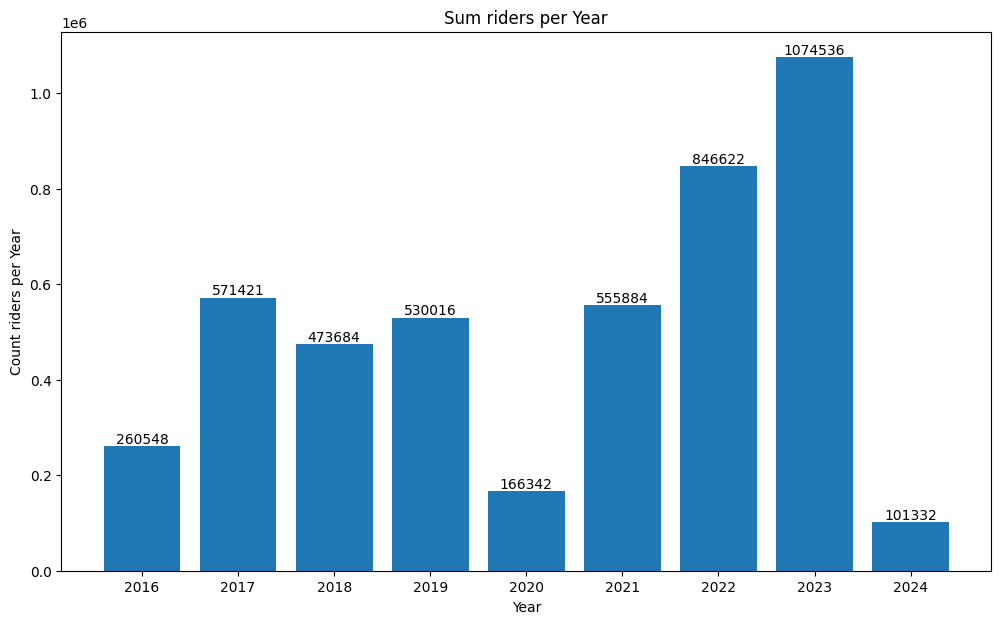

In [53]:
# Start by creating a copy of the date_counts_df DataFrame to ensure we don't modify the original dataset directly.
df = df_rides.copy()

# Extract the year from the 'date' column and create a new 'year' column.
# This step simplifies our analysis by allowing us to look at yearly trends.
df['year'] = df['date'].dt.year

# It's a good idea to drop NaN values after conversion
df = df.dropna(subset=['rides'])

# Group the data by 'year' and sum up the 'rides' column for each year.
# This aggregation gives us the total number of rides for each year.
yearly_sum = df.groupby('year')['rides'].sum().reset_index()

# Plotting the yearly trend as a bar graph to visually analyze how rides have changed over the years.
plt.figure(figsize=(12, 7))  # Set figure size to 12x7 for better visibility of the plot.
bars = plt.bar(yearly_sum['year'], yearly_sum['rides'])  # Create a bar graph with years on the x-axis and counts on the y-axis.
plt.xlabel('Year')  # Label for the x-axis.
plt.ylabel('Count riders per Year')  # Label for the y-axis.
plt.title('Sum riders per Year')  # Title of the plot.
plt.xticks(yearly_sum['year'])  # Ensure that all years are displayed on the x-axis for clarity.

# Add the total count above each bar for easy reading and direct comparison.
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

plt.show()  # Display the plot.


## Monthly Analysis and Visualization

After exploring yearly trends, let's dive into the monthly distribution of our data. Analyzing data on a monthly basis can reveal seasonal patterns and help us understand which months experience higher or lower rides.

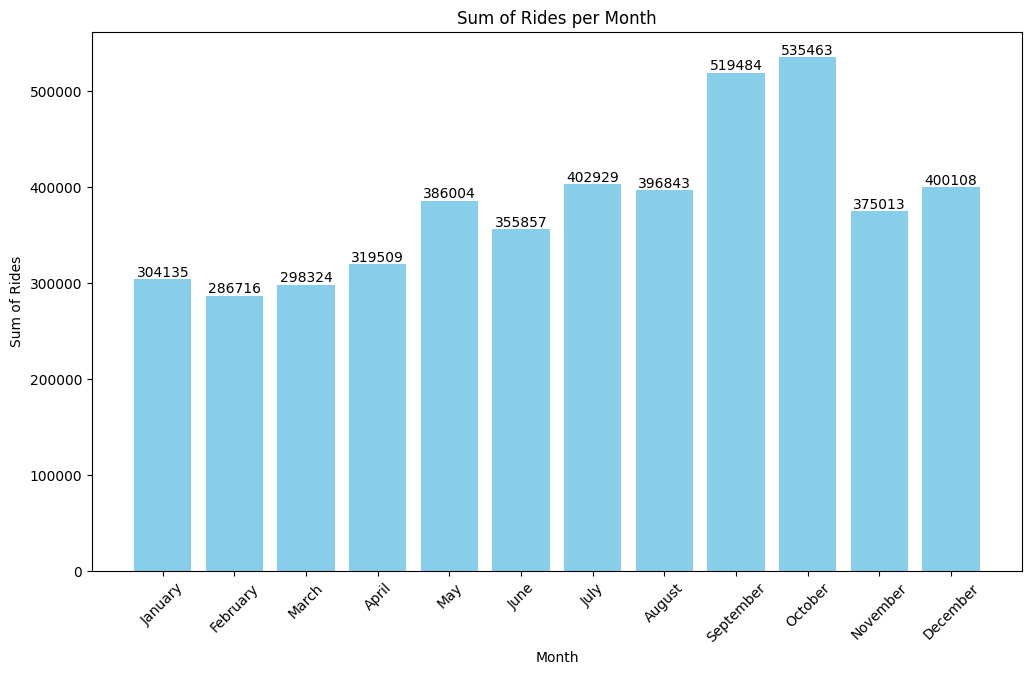

In [54]:
# Start by creating a copy of the date_counts_df DataFrame to ensure we don't modify the original dataset directly.
df = df_rides.copy()

# Add a new column 'month_name' by extracting the month name from the 'date' column.
# This helps in analyzing the data based on the calendar months.
df['month_name'] = df['date'].dt.month_name()

# Group the data by 'month_name' and sum up the 'count' column for each month.
# This aggregation helps us understand the total counts for each month across all years.
monthly_counts_named = df.groupby('month_name')['rides'].sum().reindex(
    calendar.month_name[1:], fill_value=0).reset_index()  # Reindexing to ensure all months are present and in order.


# Plotting the monthly rides as a bar graph, using month names for better readability.
plt.figure(figsize=(12, 7))  # Set figure size for clarity.
bars = plt.bar(monthly_counts_named['month_name'], monthly_counts_named['rides'], color='skyblue')  # Use a skyblue color for a visually appealing graph.
plt.xlabel('Month')  # Label for the x-axis.
plt.ylabel('Sum of Rides')  # Label for the y-axis.
plt.title('Sum of Rides per Month')  # Title of the graph.
plt.xticks(rotation=45)  # Rotate month names on the x-axis for better legibility.

# Add the total count above each bar for immediate visualization of values.
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

plt.show()  # Display the plot.


## Weekly Pattern Analysis and Visualization

Delving deeper into our time series data, we now explore how counts vary across different days of the week. This analysis is key to uncovering weekly cycles and understanding how behavior or events change from Monday to Sunday.


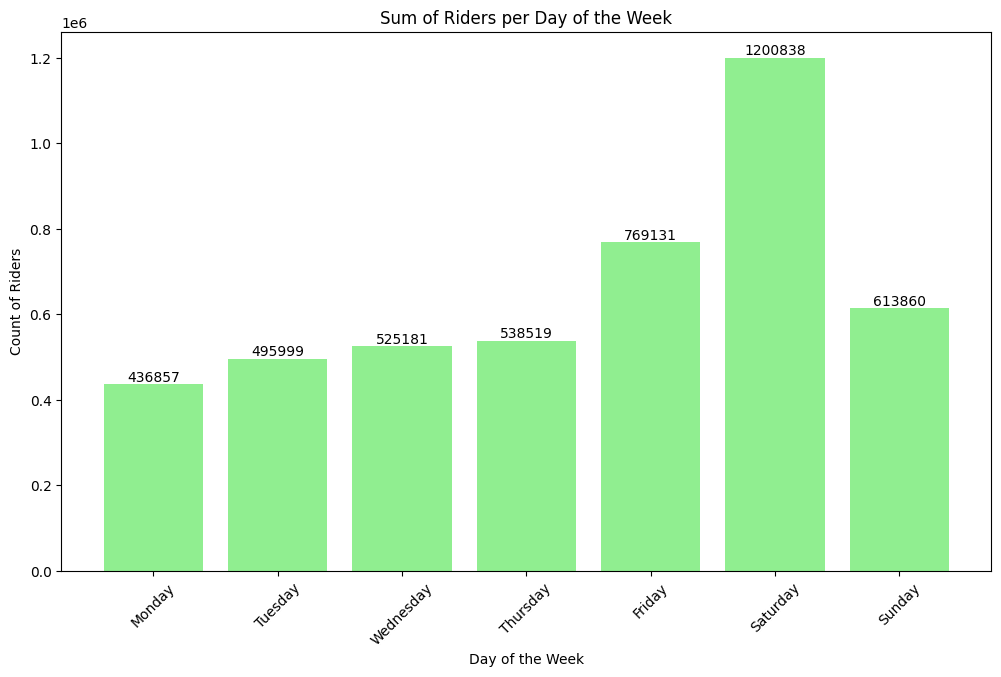

In [55]:
# Start with a fresh copy of the date_counts_df DataFrame to ensure the original data remains unchanged.
df = df_rides.copy()

# Add a 'day_of_week' column by extracting the name of the day from the 'date' column.
# This step is essential for analyzing daily trends within a week.
df['day_of_week'] = df['date'].dt.day_name()

# To ensure the days of the week are in a logical order, we explicitly define the order starting with Monday.
# This ordering is crucial for meaningful visualization and comparison.
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=ordered_days, ordered=True)

# Group the data by 'day_of_week' and sum up the 'count' column for each day.
# This aggregation allows us to see which days of the week have higher counts, indicating weekly patterns.
weekly_counts = df.groupby('day_of_week')['rides'].sum().reset_index()

# Plotting the weekly counts as a bar graph for a clear visual representation of the data.
plt.figure(figsize=(12, 7))  # Set figure size to ensure the graph is easily readable.
bars = plt.bar(weekly_counts['day_of_week'], weekly_counts['rides'], color='lightgreen')  # Use light green color for bars for a visually appealing contrast.
plt.xlabel('Day of the Week')  # Label for the x-axis.
plt.ylabel('Count of Riders')  # Label for the y-axis.
plt.title('Sum of Riders per Day of the Week')  # Title of the graph.
plt.xticks(rotation=45)  # Rotate day names for better legibility.

# Add the total count above each bar to provide a clear, immediate understanding of the values.
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

plt.show()  # Display the plot.


## Analyzing Trends on a Monthly Basis

To deepen our understanding of the data's temporal dynamics, we now turn our attention to monthly variations. By resampling our dataset on a monthly basis, we can observe how the number of accidents fluctuates over time, revealing patterns that might be obscured in a more aggregated analysis.

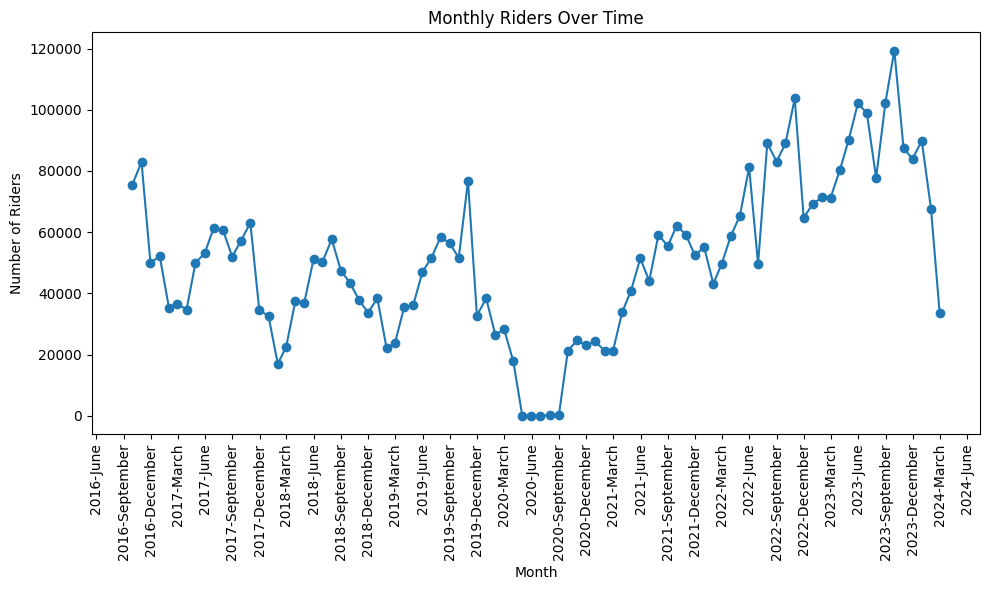

In [56]:
# Create a copy of the DataFrame for focused monthly analysis.
df_month = df_rides.copy()

# Setting the 'date' column as the DataFrame index simplifies time-based operations like resampling.
df_month.set_index('date', inplace=True)

# Resample the dataset by month ('M') and sum up the counts for each month.
# This resampling aggregates data on a monthly basis, providing a clearer view of monthly trends.
monthly_rides = df_month.resample('M').sum()

# Plotting the monthly rides data using a line plot for a continuous time series visualization.
plt.figure(figsize=(10, 6))  # Specify the figure size for clarity.
plt.plot(monthly_rides.index, monthly_rides['rides'], marker='o', linestyle='-')  # Add markers for each data point for better visibility.

# Set major ticks on the x-axis to every 3rd month to avoid clutter and enhance readability.
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

# Format the x-axis labels to display both the year and month for easy identification of specific time periods.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%B'))

# Rotate x-axis labels to ensure they do not overlap and are easy to read.
plt.xticks(rotation=90)

# Add a title and axis labels to the plot to describe the data being visualized.
plt.title('Monthly Riders Over Time')  # Provide context for what the graph represents.
plt.xlabel('Month')  # Indicate that the x-axis shows months.
plt.ylabel('Number of Riders')  # Indicate that the y-axis represents the total number of accidents.

# Use tight_layout to automatically adjust subplot parameters to give specified padding and fit the plot within the figure area.
plt.tight_layout()
plt.show()  # Display the plot to visualize the monthly trend of accidents.


## Recent Daily Analysis

To gain insights into the most current trends within our dataset, we'll narrow our focus to the last three months. This timeframe can reveal short-term fluctuations and patterns in the data, such as daily variations in counts. By examining this more recent segment, we can identify any emerging trends or changes in behavior that might require closer attention or could influence future predictions.


<ipython-input-57-4c8b67c42dcc>:19: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  filtered_df = df_day[df_day['date'] >= three_months_ago]


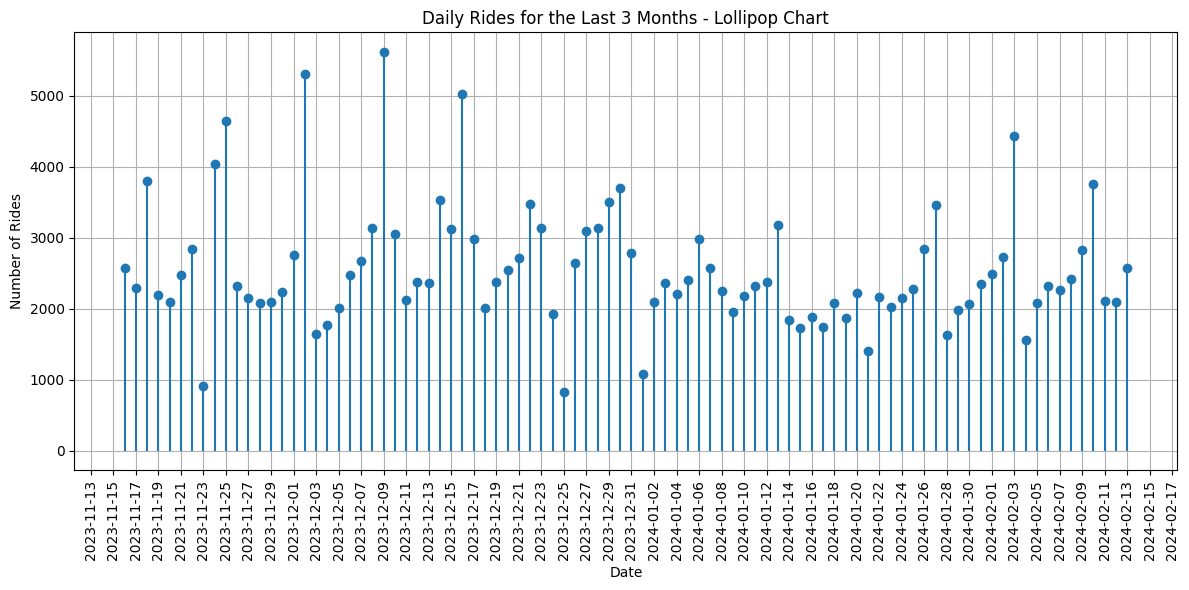

In [57]:
# Start by creating a copy of the original DataFrame to work with the daily data.
df = df_rides.copy()

# Extract just the date component from the 'date' column to simplify daily analysis.
df['date_only'] = df['date'].dt.date

# Group the data by the new 'date_only' column and sum the counts for each day.
# This gives us the total counts per day, which is useful for daily trend analysis.
daily_counts = df.groupby('date_only')['rides'].sum().reset_index()

# Optionally, rename 'date_only' back to 'date' for clarity and consistency with previous naming conventions.
daily_counts.rename(columns={'date_only': 'date'}, inplace=True)

# Prepare for analyzing the last three months by copying the daily_counts DataFrame.
df_day = daily_counts.copy()

# Calculate the date for three months ago from today to filter the dataset.
three_months_ago = dt.datetime.now() - pd.DateOffset(months=3)
filtered_df = df_day[df_day['date'] >= three_months_ago]

# Plotting the data for the last three months using a lollipop plot for a clear and engaging visualization.
plt.figure(figsize=(12, 6))
plt.stem(filtered_df['date'], filtered_df['rides'], basefmt=' ')  # Use stem plot (lollipop) for visualization.

# Set the formatter for the x-axis to display dates in 'Year-Month-Day' format.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# Use a locator to place ticks on the x-axis every two days to avoid clutter.
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Rotate the x-axis labels to ensure they are readable.
plt.xticks(rotation=90)

# Add a title, x-axis label, and y-axis label to the plot to provide context and clarity.
plt.title('Daily Rides for the Last 3 Months - Lollipop Chart')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.grid(True)  # Add a grid to the plot for easier interpretation of the data.
plt.tight_layout()  # Adjust the layout to ensure everything fits well within the plot area.
plt.show()  # Display the plot.


## Step 5: **Forecasting**

## Preparing Our Data for Forecasting

A critical step in any time series forecasting task is to divide our dataset into two parts: the **training set** and the **testing set**. This split allows us to train our forecasting model on a portion of the data (training set) and then evaluate its performance on unseen data (testing set). The goal is to simulate how well our model will perform in the future, using data it hasn't seen during the training process.

For our analysis, we'll use the most recent three months of data as our testing set. This approach ensures that our model is evaluated against the most current trends and patterns in our dataset. Let's split our data accordingly and take a closer look at the testing set to see what our model will be working with.


In [58]:
# Create a copy of the original DataFrame to ensure we don't alter the original data while splitting.
df_pred = df_rides.copy()

# Determine the start date for the test data by subtracting 3 months from the maximum (most recent) date in the dataset.
# This approach ensures that the test set includes the most recent data.
test_start_date = df_pred['date'].max() - pd.DateOffset(months=3)

# Split the DataFrame into training and testing sets:
# - The training set will include data before the test start date.
# - The testing set will include data from the test start date onwards.
train_df = df_pred[df_pred['date'] < test_start_date]  # Data for training the model.
test_df = df_pred[df_pred['date'] >= test_start_date]  # Data for testing the model's predictions.

# Print the testing set to verify the split and to understand the time frame of the data we'll be using for testing.
test_df


,date,rides
2533,2023-11-13,2298
2534,2023-11-14,2507
2535,2023-11-15,2452
2536,2023-11-16,2579
2537,2023-11-17,2286
...,...,...
2621,2024-02-09,2832
2622,2024-02-10,3759
2623,2024-02-11,2114
2624,2024-02-12,2094


## Modeling Time Series Data with Exponential Smoothing

Now that we've prepared our dataset by cleaning it and splitting it into training and testing sets, it's time to start forecasting. We'll use the **Exponential Smoothing (ETS)** model, a robust method for time series forecasting that can account for data trends and seasonality.

Exponential Smoothing models are particularly powerful because they can be adapted to datasets with various patterns. By specifying the type of trend and seasonality (additive or multiplicative), we can tailor the model to our specific dataset, improving the accuracy of our forecasts.

In our case, we'll configure the model to recognize an additive trend and seasonality, anticipating that these components will linearly affect our data. This setup is ideal for handling consistent changes over time and capturing weekly patterns, given our dataset's nature.

Let's proceed to train our model on the training set, setting the stage for making predictions and evaluating its performance on our test data.


In [59]:
# Initialize and train the Exponential Smoothing model.
# The Exponential Smoothing (ETS) model is a time series forecasting method that combines exponential smoothing for errors (E),
# trend (T), and seasonality (S), making it well-suited for datasets with patterns in these areas.

# Here's how we configure the model:
# - `trend='add'` specifies an additive trend component, suggesting that the trend is linear over time.
# - `seasonal='add'` specifies an additive seasonal component, suitable for when seasonal effects are roughly the same magnitude throughout the series.
# - `seasonal_periods=7` indicates the length of the seasonal cycle, which we've set to 7 to capture weekly seasonality.
model = ExponentialSmoothing(train_df['rides'],
                             #trend='add',
                             seasonal='add',
                             seasonal_periods=7).fit()
# The `.fit()` method is called to estimate the model parameters and fit the model to the training data.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## Forecasting and Evaluating Model Performance

With our Exponential Smoothing model trained, we're now at a critical juncture: forecasting future values and assessing our model's accuracy. Forecasting involves using our model to predict future data points based on the patterns learned during training. It's a powerful way to see how well our model understands the data and can simulate future conditions.

After generating forecasts for the next three months, we'll compare these predictions against the actual data in our test set. This comparison is not just about validating our model's predictions; it's about learning how close we are to the real-world outcomes and where we might need to adjust our modeling approach.

By examining the forecasted versus actual counts, we can gauge the model's performance and identify areas for improvement, refining our approach to forecasting as we gain insights.


In [60]:
# Forecast the next three months using the trained Exponential Smoothing model.
# The `forecast` method generates future values based on the length of the test dataset, which corresponds to the next three months in our case.
forecast = model.forecast(len(test_df))

# Create a DataFrame to compare the actual counts with the forecasted counts.
# This comparison is crucial for evaluating the accuracy and effectiveness of our forecasting model.
forecast_comparison = pd.DataFrame({
    'Date': test_df['date'],  # Dates from the test set to serve as the index.
    'Actual': test_df['rides'],  # Actual counts from the test set.
    'Forecast': forecast.values  # Forecasted counts generated by our model.
})



## Advancing with Prophet for Time Series Forecasting

After exploring traditional time series models, we're now turning our attention to Prophet, a forecasting tool developed by Facebook that's designed for ease of use and handling data with strong seasonal effects. Prophet stands out for its ability to deal with missing data, shifts in the trend, and large outliers effectively.


In [61]:
# Prepare the DataFrame for Prophet by renaming columns to 'ds' and 'y'.
# Prophet requires the DataFrame to have a 'ds' column for dates and a 'y' column for the values we want to predict.
df_pred = df_pred.rename(columns={'date': 'ds', 'rides': 'y'})

# Determine the start date for the test data by subtracting 3 months from the most recent date in the dataset.
test_start_date = df_pred['ds'].max() - pd.DateOffset(months=3)

# Split the dataset into training data (before the test start date) and leave the test data for later comparison.
train_df = df_pred[df_pred['ds'] < test_start_date]

# Initialize the Prophet model.
model = Prophet()

# Fit the model on the training dataset.
model.fit(train_df)

# Create a DataFrame that extends into the future for the next 90 days (approximately 3 months).
# The exact number of days may need to be adjusted based on the specific months being forecasted.
future = model.make_future_dataframe(periods=93)

# Use the model to predict the future values.
# The 'forecast' DataFrame will contain the forecasted values along with several components of the forecast.
forecast = model.predict(future)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdfzfq9m4/fu2j5u1m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdfzfq9m4/nm4v49vt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69508', 'data', 'file=/tmp/tmpdfzfq9m4/fu2j5u1m.json', 'init=/tmp/tmpdfzfq9m4/nm4v49vt.json', 'output', 'file=/tmp/tmpdfzfq9m4/prophet_modelevykx8zw/prophet_model-20240216193748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:37:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:37:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Step 6: **Analyzing Results**

## Visualizing and Comparing Forecast Results

After generating forecasts using both the Exponential Smoothing (ETS) model and Facebook's Prophet model, it's essential to visualize and compare these predictions against the actual data. This step not only helps us assess the accuracy of each model but also provides insights into their performance under different conditions.

By plotting the actual accident counts alongside the forecasts from both models, we can visually gauge how well each model captures the underlying trends and seasonality in the data. This comparative analysis is crucial for understanding the strengths and limitations of each forecasting approach and guiding decisions on model selection based on the specific characteristics of the dataset.

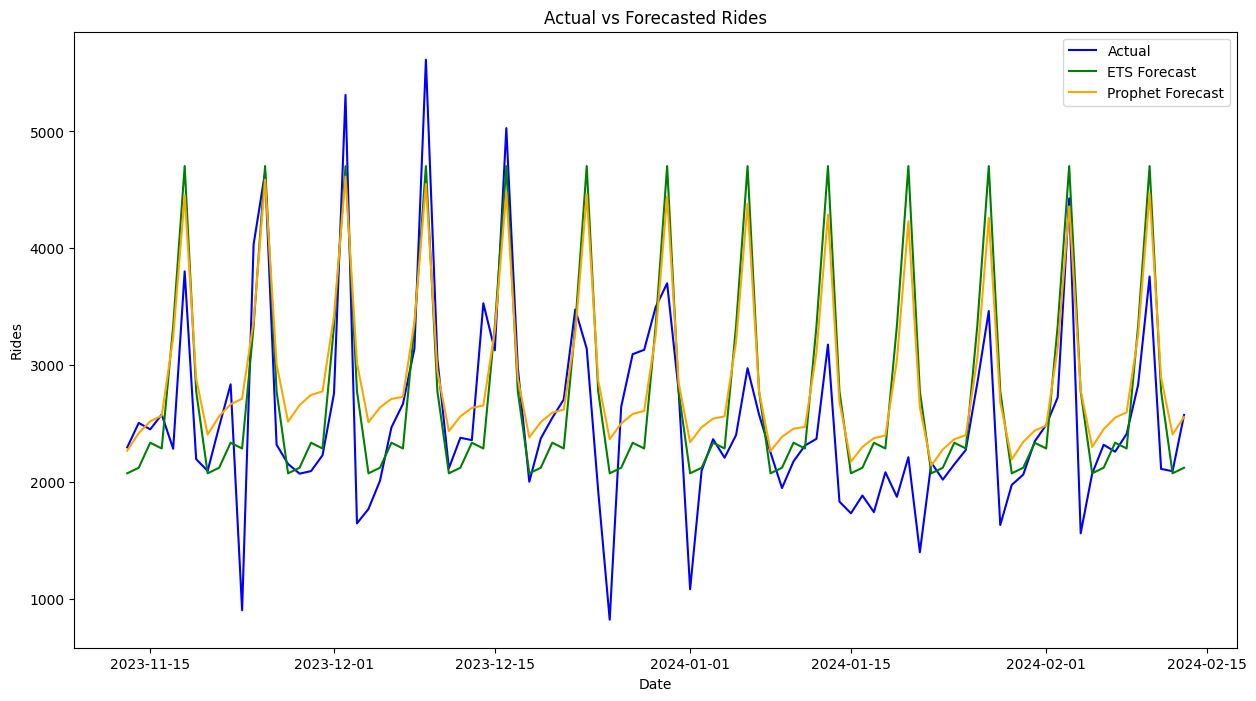

In [62]:
# Step 1: Prepare the forecast data from Prophet for comparison by selecting relevant columns.
# We focus on 'ds' for the date and 'yhat' for the forecasted values, renaming them for consistency with our comparison DataFrame.
prophet_forecast = forecast[['ds', 'yhat']].rename(columns={'ds': 'Date', 'yhat': 'Prophet_Forecast'})

# Ensure both 'Date' columns have the same data type by removing timezone information if present
forecast_comparison['Date'] = forecast_comparison['Date'].dt.tz_localize(None)
prophet_forecast['Date'] = prophet_forecast['Date'].dt.tz_localize(None)

# Step 2: Merge the Prophet forecast data with the existing comparison DataFrame.
# This allows us to directly compare the actual counts, the ETS model forecasts, and the Prophet forecasts.
combined_forecast_comparison = forecast_comparison.merge(prophet_forecast, on='Date', how='left')

# Plotting the comparison of actual data with forecasts from both ETS and Prophet models.
plt.figure(figsize=(15, 8))

# Plot the actual data in blue for clarity and direct comparison.
plt.plot(combined_forecast_comparison['Date'], combined_forecast_comparison['Actual'], label='Actual', color='blue')

# Plot the ETS model forecast in green, showing the model's predictions against the actual data.
plt.plot(combined_forecast_comparison['Date'], combined_forecast_comparison['Forecast'], label='ETS Forecast', color='green')

# Plot the Prophet model forecast in orange, highlighting its predictions.
plt.plot(combined_forecast_comparison['Date'], combined_forecast_comparison['Prophet_Forecast'], label='Prophet Forecast', color='orange')

# Add labels to the x-axis and y-axis, and a title to the plot for context.
plt.xlabel('Date')
plt.ylabel('Rides')
plt.title('Actual vs Forecasted Rides')

# Include a legend to distinguish between the actual data and the forecasts from the two models.
plt.legend()

# Display the plot, showcasing the comparison of actual counts with the forecasts.
plt.show()


## Evaluating Model Performance with MAPE

In forecasting, accurately measuring model performance is crucial to understanding how well our predictions align with actual outcomes. One of the key metrics for this purpose is the **Mean Absolute Percentage Error (MAPE)**, which quantifies the average magnitude of errors as a percentage of actual values. This metric is particularly useful because it provides an intuitive sense of the forecast accuracy in relative terms.

In [63]:
# Filter the combined forecast DataFrame to exclude any rows where actual data might be missing.
# This ensures that our MAPE calculation only considers days with both actual and forecasted values.
filtered_df = combined_forecast_comparison.dropna(subset=['Actual'])

# Calculate the Mean Absolute Percentage Error (MAPE) for the ETS model.
# MAPE measures the size of the error in percentage terms, providing an intuitive metric of forecast accuracy.
ets_mape = 100 * (filtered_df['Actual'] - filtered_df['Forecast']).abs() / filtered_df['Actual']
ets_mape = ets_mape.mean()  # Compute the average MAPE across all days in the test set for the ETS model.

# Calculate the MAPE for the Prophet model using the same approach.
# This allows for a direct comparison of forecast accuracy between the two models.
prophet_mape = 100 * (filtered_df['Actual'] - filtered_df['Prophet_Forecast']).abs() / filtered_df['Actual']
prophet_mape = prophet_mape.mean()  # Compute the average MAPE for the Prophet model.

# Create a summary table to display the MAPE values for both forecasting methods.
# This table provides a clear, concise comparison of model performance.
mape_summary = pd.DataFrame({
    'Method': ['ETS', 'Prophet'],  # Specify the forecasting methods being compared.
    'MAPE': [ets_mape, prophet_mape]  # List the calculated MAPE values for each method.
})

# Display the summary table, offering insights into which model performs better on our dataset based on the MAPE metric.
mape_summary


,Method,MAPE
0,ETS,22.817566
1,Prophet,24.514505


## Summary and Key Takeaways

Throughout this course, we embarked on a comprehensive journey through the world of time series forecasting, equipped with Python and its powerful libraries. We began by introducing the fundamentals of time series data, emphasizing its importance in making informed predictions about future events based on historical patterns.

**Key Steps Covered:**
- **Data Cleaning and Preparation:** We learned the importance of cleaning and organizing our data, ensuring it's in the right format for analysis and modeling.
- **Exploratory Data Analysis (EDA):** Visualizing our data helped us identify trends, seasonality, and other patterns critical for selecting appropriate forecasting models.
- **Modeling with ETS and Prophet:** We explored two powerful forecasting methods. The Exponential Smoothing (ETS) model helped us understand classical time series forecasting techniques, while Facebook's Prophet model introduced us to a more modern approach that easily handles seasonal data and trends.
- **Evaluation and Comparison:** By calculating the Mean Absolute Percentage Error (MAPE) for each model, we quantitatively assessed their performance, learning that no single model is best for all situations.

**Insights Gained:**
- Forecasting accuracy varies by model and data. Our evaluation showed that both ETS and Prophet have their strengths, with their performance depending on the specific characteristics of the dataset.
- Understanding the underlying patterns in your data (like seasonality and trends) is crucial for selecting and tuning your forecasting model.
- Quantitative evaluation, such as using MAPE, is essential for comparing model performances objectively, guiding us toward the most effective model for our forecasting needs.

**Looking Forward:**
As we conclude, remember that forecasting is as much an art as it is a science. It involves understanding your data, selecting the right tools, and continuously refining your models based on performance metrics and business understanding.

This course has laid the foundation for your journey into time series forecasting. Whether you're predicting stock prices, forecasting weather, or planning inventory, the skills you've developed here will serve as a valuable asset in your data science toolkit.

Thank you for joining me on this exploratory journey through time series analysis and forecasting. Here's to many more predictive insights in your future endeavors!
